In [189]:
%matplotlib inline
#The libraries we are going to use are PySerial and Time
# PySerial is encapsulates the access for the serial port.
import serial
import time
import numpy as np
# script that allow to set the graphs for the signal
#from graph import *
# Matplotlib to draw functions
import matplotlib.pyplot as plt
# To allow make live data graph we need drawnow
# pip install drawnow
# Librerias para graficar
from drawnow import *
from IPython import display
import matplotlib.animation as animation
from IPython.display import HTML

In [190]:
# Opening a Serial port

# - The port is immediately opened on object creation, when a port is given. It is not opened when
# port is None and a successive call to open() is required. port is a device name: depending on 
# operating system. e.g. /dev/ttyUSB0 on GNU/Linux or COM3 on Windows.
# - The parameter baudrate can be one of the standard values:  50, 75, 110, 134, 150, 200, 300, 600, 1200,
# 1800, 2400, 4800, 9600, 19200, 38400, 57600, 115200. These are well supported on all platforms.
# - Standard values above 115200, such as:  230400, 460800, 500000, 576000, 921600, 1000000, 1152000,
# 1500000, 2000000, 2500000, 3000000, 3500000, 4000000 also work on many platforms and devices.
# Non-standard values are also supported on some platforms (GNU/Linux, MAC OSX >= Tiger, Windows).
# - Possible values for the parameter timeout which controls the behavior of read():
# .. timeout = None: wait forever until requested number of bytes are received
# .. timeout = 0:  non-blocking mode, return immediately in any case, returning zero or more, up to
# the requested number of bytes
# .. timeout = x:  set timeout to x seconds (float allowed) returns immediately when the requested
# number of bytes are available, otherwise wait until the timeout expires and return all bytes that were
# received until then.
DEMOQE_read = serial.Serial('/dev/ttyUSB0',115200,timeout=1);
print(DEMOQE_read.isOpen())

True


In [191]:
# Set the matplotlib parameters, initializing
plt.ion() # Modo interactivo de matplotlib
# VARIABLES para almacenar los valores de los sensores en el tiempo
digital_1 = []
digital_2 = []
analogico_1 = []
analogico_2 = []
# Constantes de manipulacion para el main
flag_first_run = 0
flag_trama_len_cst = 0
list_pos_trama = []
i = 0
data_list = []
time_list = []

In [192]:
#Hex to binary
def dec_to_bin(dec):
    dec_str = str(int(dec))
    cod_bin = bin(int(dec_str))
    return cod_bin

In [193]:
#Binary to decimal
def bin_to_dec(bina):
    cod_dec = int(str(bina),2)
    return cod_dec

In [194]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 D1 D2 A11 A10 A9 A8 A7
def decode_channel1_one(number):
    #decode Channel one
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    digital_one = part_one_bin_comp[1]
    digital_two = part_one_bin_comp[2]
    analogic_most_significant = part_one_bin_comp[3:]
    return digital_one,digital_two,str(analogic_most_significant)

In [195]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 A6 A5 A4 A3 A2 A1 A0
def decode_channel12_two(number):
    #decode channe one and two for less significant bits
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    analogic_less_significant = part_one_bin_comp[1:]
    return str(analogic_less_significant)

In [196]:
# This function make possible to split an integer number to separate the information we want.
# First we have to translate the hexa code to binary. Second we save every bit following the
# protocol order:
# 0 0 0 A11 A10 A9 A8 A7
def decode_channel2_one(number):
    # decode channel two for most significant bits
    part_one_bin = dec_to_bin(number)
    len_bit_number = len(part_one_bin) -2
    diferencia = 8 - len_bit_number
    cero_faltante = "0"*diferencia
    part_one_bin_comp = (cero_faltante + str(part_one_bin[2:]))
    analogic_most_significant = part_one_bin_comp[3:]
    return str(analogic_most_significant)

In [197]:
# We need to concatened the entirely analogic information.
def concatenation(string1,string2):
    return bin_to_dec(int(string1 + str(string2)))

In [198]:
def makeFig(): #Create a function that makes our desired plot
    plt.title('My Live Streaming Sensor Data')     
    plt.grid(True)                                  
    plt.ylabel('amplitud')                            
    plt.xlabel('time')
    plt.plot(analogico_1)       
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [199]:
while True:
    try:
# To find the Serial port direction we can get the name typing python in the terminal:
# $ python -m serial.tools.list_ports -v
# NOTE: The microcontroller must be connected
        while (DEMOQE_read.inWaiting()==0):
            #print("No data in port")
            pass
        # Se recibiran 5 bytes por el puerto serial segun el protocolo
        #time.sleep(0.000001)
        DEMOQE_read.flush()
        data_input_2 = DEMOQE_read.read(5)
        data_list.append(data_input_2)
        time_list.append(i)
        i+=0.0005
        
    except:
        print("Keyboard interrupt")
        DEMOQE_read.close()
        break

Keyboard interrupt


In [200]:
flag_first_run = 0
for data_input in data_list:
    #Codigo 
    flag_trama_len_cst = 0
    list_pos_trama = []
    enc_posi = data_input.find(245)
    # Chequeo de encabezado en la primera casilla
    if enc_posi==0:
        flag_first_run=0
    # Longitud de la trama
    trama_length = len(data_input)
    if trama_length!=5:
        continue
    posiciones = trama_length - enc_posi -1
    # Chequeo de encabezado en su ultima casilla
    if posiciones==0:
        flag_first_run=1
    # Entrando formato de la primera corrida
    if (flag_first_run==0):
        for pos in range(posiciones):
            list_pos_trama.append(enc_posi +pos+1)
        for pos_dato_trama in list_pos_trama:
            if (pos_dato_trama == enc_posi +1):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi + 2):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b)*3)
                flag_trama_len_cst += 1
                if enc_posi==2:
                    flag_trama_len_cst=0
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi + 3):
                if enc_posi==1:
                    flag_trama_len_cst=0
                    flag_first_run=1
                    analogic_l_b = decode_channel12_two(data_input[0])
                    analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi + 4):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
            else:
                flag_first_run=1
                if (flag_trama_len_cst == 4):
                    flag_trama_len_cst = 0
                    flag_first_run=0
    else:
        posiciones = trama_length - enc_posi -1
        # Verificar que llegaron los dos canales completos
        for pos_dato_trama in range(enc_posi):
            if (pos_dato_trama == enc_posi -1):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_2.append(concatenation(auxiliar2,analogic_l_b))
                flag_trama_len_cst += 1
                if enc_posi==1:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[2])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[3])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    analogic_m_b = decode_channel2_one(data_input[4])
                    auxiliar2 = analogic_m_b
                    flag_first_run=1
                if enc_posi==2:
                    # Agregando la posicion 3 antes de salir
                    digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[3])
                    digital_1.append(digital_one)
                    digital_2.append(digital_two)
                    auxiliar = analogic_m_b
                    # Agregando la ultima posicion antes de salir
                    analogic_l_b = decode_channel12_two(data_input[4])
                    analogico_1.append(concatenation(auxiliar,analogic_l_b))
                    flag_first_run=1
            elif (pos_dato_trama == enc_posi -2):
                analogic_m_b = decode_channel2_one(data_input[pos_dato_trama])
                auxiliar2 = analogic_m_b
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -3):
                analogic_l_b = decode_channel12_two(data_input[pos_dato_trama])
                analogico_1.append(concatenation(auxiliar,analogic_l_b))
                flag_trama_len_cst += 1
            elif (pos_dato_trama == enc_posi -4):
                digital_one,digital_two,analogic_m_b = decode_channel1_one(data_input[pos_dato_trama])
                digital_1.append(digital_one)
                digital_2.append(digital_two)
                auxiliar = analogic_m_b
                flag_trama_len_cst += 1
            else:
                flag_trama_len_cst = 0
                flag_first_run = 0

In [201]:
analogico_1_V2 = [x*3/4095 for x in analogico_1]
print(len(time_list))
print(len(analogico_1_V2))

3625
3625


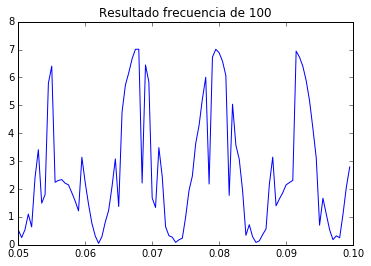

In [202]:
plt.plot(time_list[100:200],analogico_1_V2[100:200])
plt.title("Resultado frecuencia de 100")
plt.savefig("f100.png")